In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [272]:
# 1) Загрузка данных и первичный осмотр

df = pd.read_csv('../../../Семинары/2/S02-hw-dataset.csv')
df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41 entries, 0 to 40
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   user_id    41 non-null     int64  
 1   age        39 non-null     float64
 2   country    41 non-null     object 
 3   purchases  41 non-null     int64  
 4   revenue    41 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 1.7+ KB


In [274]:
df.describe()

,user_id,age,purchases,revenue
count,41.000000,39.000000,41.000000,41.000000
mean,20.243902,36.512821,4.829268,820.048780
std,11.659289,18.304259,2.710189,613.127269
min,1.000000,5.000000,-1.000000,0.000000
25%,10.000000,24.000000,3.000000,432.000000
50%,20.000000,33.000000,5.000000,693.000000
75%,30.000000,45.500000,7.000000,1115.000000
max,40.000000,120.000000,11.000000,2475.000000


In [275]:
# 2) Пропуски, дубликаты и базовый контроль качества
df.isna().mean()


user_id      0.00000
age          0.04878
country      0.00000
purchases    0.00000
revenue      0.00000
dtype: float64

In [276]:
# проверка дубликатов
df.duplicated()

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
34    False
35    False
36    False
37    False
38    False
39    False
40     True
dtype: bool

In [277]:
df.head()

,user_id,age,country,purchases,revenue
0,1,25.0,FR,7,749
1,2,24.0,RU,5,1115
2,3,52.0,FR,7,399
3,4,31.0,RU,6,654
4,5,NaN,DE,6,1296


In [278]:
# заменяем пропуски на медиану
df['age'] = df['age'].fillna(df['age'].median())

In [279]:
# Должны найти выбросы ? --> будем отталкиваться от IQR (Q3 - Q1)
# ! колонка age
# нижняя граница Q1 − 1.5 × IQR
# вверхняя граница Q3 + 1.5 × IQR
to_drop = set()

q1 = df['age'].quantile(0.25).item()
q3 = df['age'].quantile(0.75).item()

a = df[
    (df['age'] < q1 - 1.5 * (q3 - q1)) | 
    (df['age'] > q3 + 1.5 * (q3 - q1)) | 
    (df['age'] < 6)
]
a

,user_id,age,country,purchases,revenue
5,6,120.0,FR,-1,785
20,21,5.0,RU,8,1488


In [280]:
to_drop.update(a.index)
to_drop

{5, 20}

In [281]:
# теперь мы должны проверить колонку purchases,
# здесь уже нужно применить нормирование , так как
# purchases и revenue имеют взаимосвязь + качество проверим качество данных

df['rev.pur'] = df['revenue'] / df['purchases'] # нормирование
q1_r = df['rev.pur'].quantile(0.25).item()
q3_r = df['rev.pur'].quantile(0.75).item()
iqr_r = q3_r - q1_r #IQR

r = df[ 
    (df['rev.pur'] < q1_r - 1.5 * iqr_r) |
    (df['rev.pur'] > q3_r + 1.5 * iqr_r) |
    ((df['purchases'] == 0) & df['revenue'] != 0)
]
r

,user_id,age,country,purchases,revenue,rev.pur
5,6,120.0,FR,-1,785,-785.0


In [282]:
to_drop.update(r.index)

In [283]:
# колонка purchases и revenue - корректность данных

p = df[(df['purchases'] == 0) | (df['revenue'] == 0)]
p

,user_id,age,country,purchases,revenue,rev.pur
6,7,46.0,RU,0,0,NaN
10,11,24.0,US,4,0,0.0
17,18,24.0,RU,0,0,NaN
33,34,28.0,FR,0,0,NaN


In [284]:
to_drop.update(p.index)
df = df.drop(to_drop)

In [285]:
df.shape

(35, 6)

Описание выбросов и качества данных.

1) Основным способом проверки был IQR (межквартальный размах). Если значение было меньше нижней границы или выше верхней, то в таком случае оно считалось выбросом. В данном случае мы можем увидеть два разных случая, где в обоих были эти выбросы найдены.

2) При проверке столбца "age" мы делали базовую проверку через IQR, где мы находим Q1 (первый квартиль) и Q3 (третий квартиль), чтобы получить IQR и далее через фильтрацию с помощью заданных границ находить выбросы. Был найден выброс под индексом 5, где покупателю 120 лет - очень подозрительный возраст, и под индексом 20 - нашему покупателю оказалось 5 лет, это уже проблема качества данных, а не выброс, в фильтре у нас так же используется проверка на это (df['age'] < 6).

3) Далее нам осталось проверить 2 столбца - это purchases и revenue, но делать это отдельно не корректно, так как в данном случае есть зависимость между ними , где revenue (Y) зависит от purchases (X), поэтому мы их нормируем и на нормированном признаке ищем выбросы. Строка под индексом 5 снова выявилась как выброс.

4) Колонка purchases и revenue, так же были отдельно проверены на качество данных где выявились еще строчки со значенями 0.
Итог работы с данными выше - все значения где были пропуски были заменены на медианные, а строчки с выбросами и не корректными данными были удалены.

In [286]:
# Базовый EDA: группировки, агрегаты и частоты
df.head()

,user_id,age,country,purchases,revenue,rev.pur
0,1,25.0,FR,7,749,107.0
1,2,24.0,RU,5,1115,223.0
2,3,52.0,FR,7,399,57.0
3,4,31.0,RU,6,654,109.0
4,5,33.0,DE,6,1296,216.0


In [ ]:
df['country'].value_counts() # частота для столбца country

country
FR    10
RU    10
US     7
DE     6
CN     2
Name: count, dtype: int64

In [ ]:
df.groupby('country')['revenue'].mean() # средняя сумма покупки в каждой из стран

country
CN    1054.0
DE    1445.5
FR     732.6
RU     878.3
US     637.0
Name: revenue, dtype: float64

In [ ]:
# вводим дополнительные «коридоры» (bins), на их основе делаем группировку

bins = [0, 18, 30, 50, 120]
labels = ['child', 'young', 'adult', 'senior']

df['age_group'] = pd.cut(df['age'], bins = bins, labels = labels)
df.groupby('age_group')['purchases'].max()

/var/folders/2l/ssnbg2td6sj2gjbsn68r19bm0000gn/T/ipykernel_19911/3419519123.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_group')['purchases'].max()


age_group
child      4
young      7
adult     11
senior     7
Name: purchases, dtype: int64

1) С помощью группировки мы смогли узнать что средняя сумма дохода больше всего в Германии (DE), а значит что и большая часть выручки приходит с этой страны.

2) Далее были введены дополнительные коридоры, с помощью которых мы разделили возраст на разные категории, после чего использовав новый столбец с нашими возрастными категориями мы сделали группировку и выявили, что большая доля покупок приходилось на взрослых людей , а меньше всего на детей.


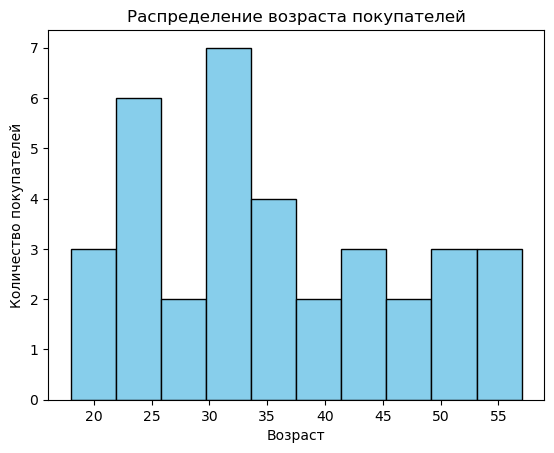

In [314]:
# Визуализация данных в Matplotlib

plt.hist(df['age'], bins=10, color='skyblue', edgecolor='black')

plt.title('Распределение возраста покупателей')  # заголовок графика
plt.xlabel('Возраст')  # подпись оси X
plt.ylabel('Количество покупателей')  # подпись оси Y

plt.savefig('figures/age_histogram.png')
plt.show()

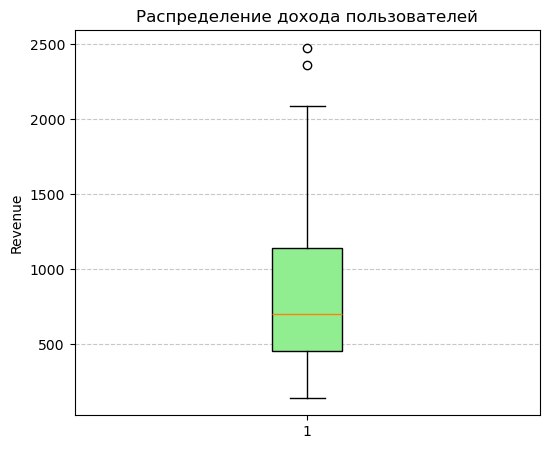

In [304]:
plt.figure(figsize=(6,5))
plt.boxplot(df['revenue'], patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Распределение дохода пользователей')
plt.ylabel('Revenue')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('figures/revenue_boxplot.png')
plt.show()

<Figure size 800x500 with 0 Axes>

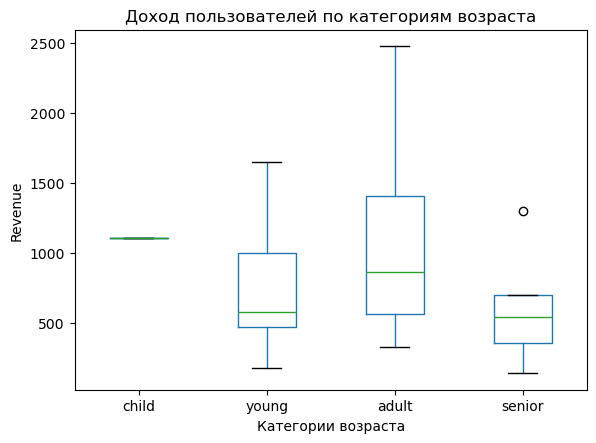

In [307]:
plt.figure(figsize=(8,5))
df.boxplot(column='revenue', by='age_group', grid=False)
plt.title('Доход пользователей по категориям возраста')
plt.suptitle('')  # убирает автоматический заголовок, который добавляет pandas
plt.xlabel('Категории возраста')
plt.ylabel('Revenue')

plt.savefig('figures/revenue_by_class_boxplot.png')
plt.show()

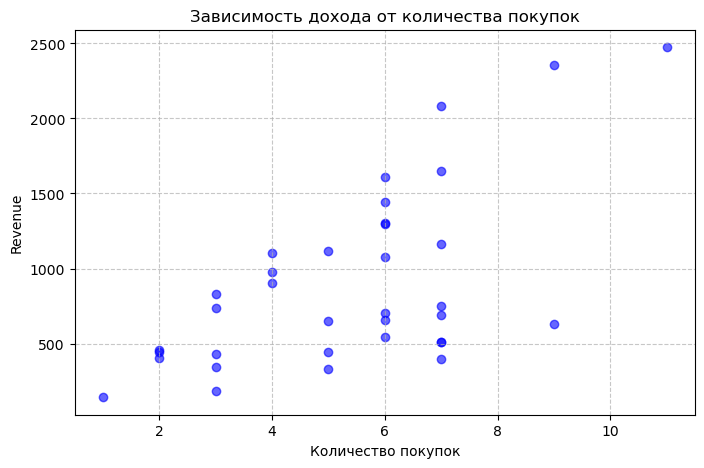

In [308]:
plt.figure(figsize=(8,5))
plt.scatter(df['purchases'], df['revenue'], c='blue', alpha=0.6)
plt.title('Зависимость дохода от количества покупок')
plt.xlabel('Количество покупок')
plt.ylabel('Revenue')
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig('figures/revenue_vs_purchases_scatter.png')
plt.show()